## 1. Import packages

In [31]:
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
import albumentations as A

device = torch.device('cpu')
path = 'images/'

## 2. Explore Data

### Creating DataFrame

In [32]:
mask_files = glob.glob(path + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [33]:
def diagnosis(mask_path):
    if np.max(cv2.imread(mask_path)) > 0:
        return 1 
    else:
        return 0

df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,1
1,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,0
2,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,1
3,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,1
4,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,images/TCGA_DU_7301_19911112/TCGA_DU_7301_1991...,0


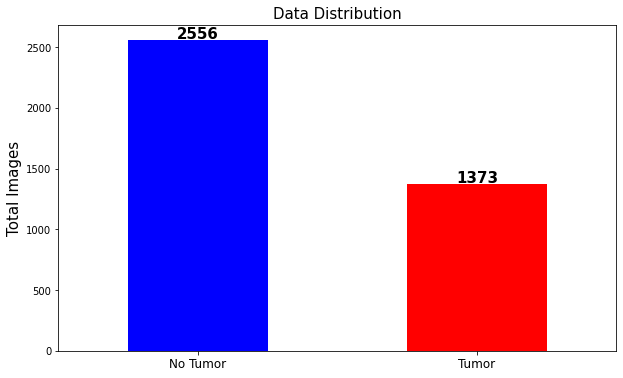

In [34]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=8, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Split data into `train`/`validation`/`test` set

In [35]:
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape}\nVal: {val_df.shape}\nTest: {test_df.shape}")

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


### Visualize Image with Mask

(-0.5, 2604.5, 520.5, -0.5)

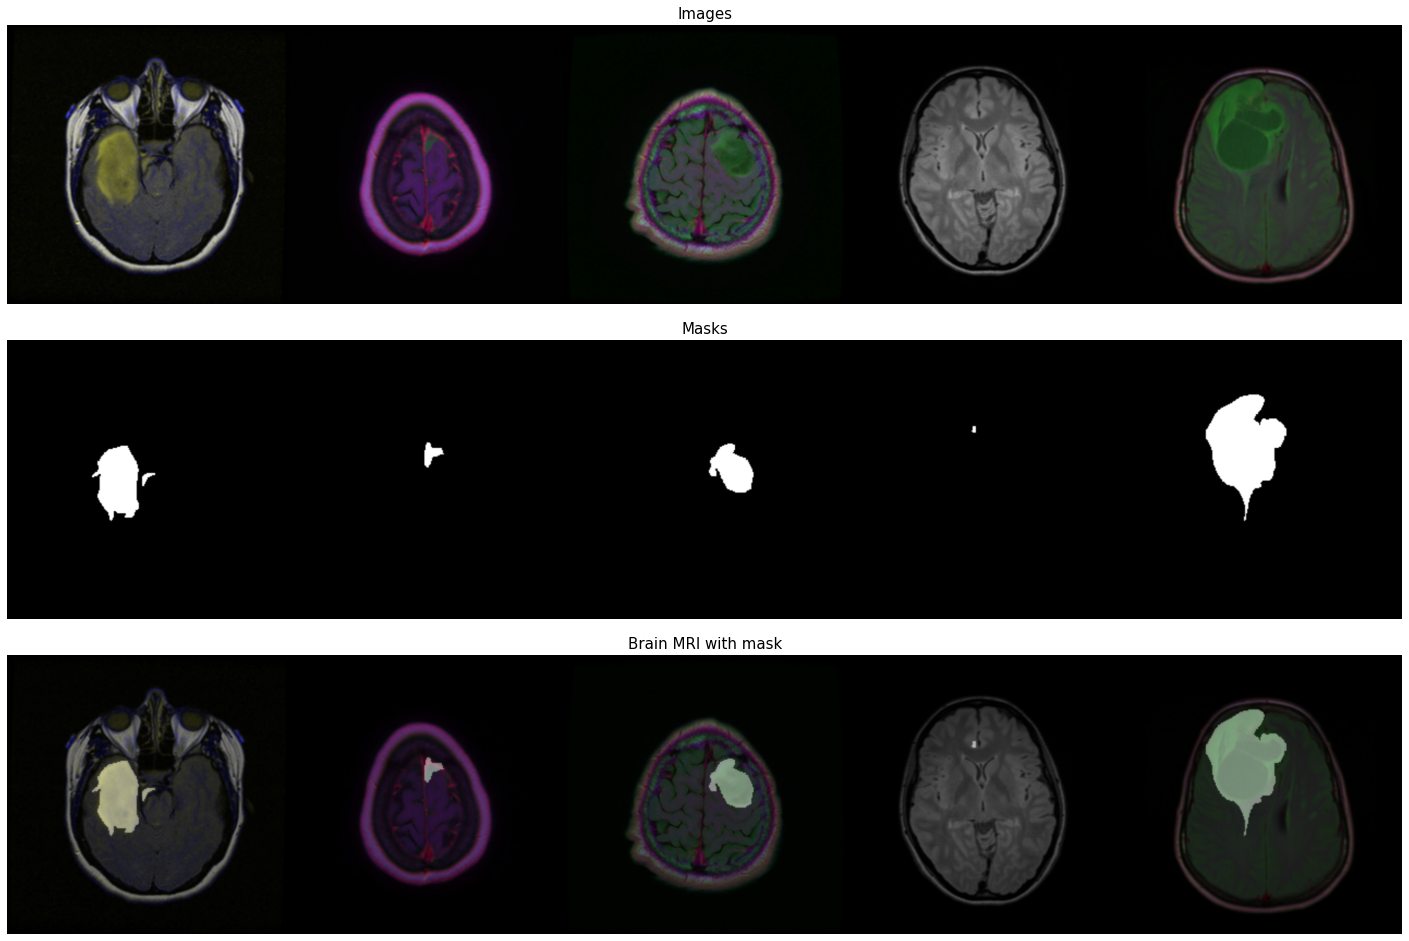

In [36]:
img_size = 521
images = []
masks = []
df_positive = df[df['diagnosis']==1].sample(5).values
for data in df_positive:
    img = cv2.resize(cv2.imread(data[0]), (img_size, img_size))
    mask = cv2.resize(cv2.imread(data[1]), (img_size, img_size))
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(25,25))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

## 3. Data Generator and Augmentation

In [38]:
class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask
    
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])
val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])
test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

### Create dataset

In [39]:
train_dataset = BrainDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=26, shuffle=True, num_workers=2)

val_dataset = BrainDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=26, shuffle=True, num_workers=2)

test_dataset = BrainDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=26, shuffle=True, num_workers=2)

In [79]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i = 0
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img * std + mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img) 
        plt.axis('off')
        i += 1
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([26, 3, 128, 128])
torch.Size([26, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

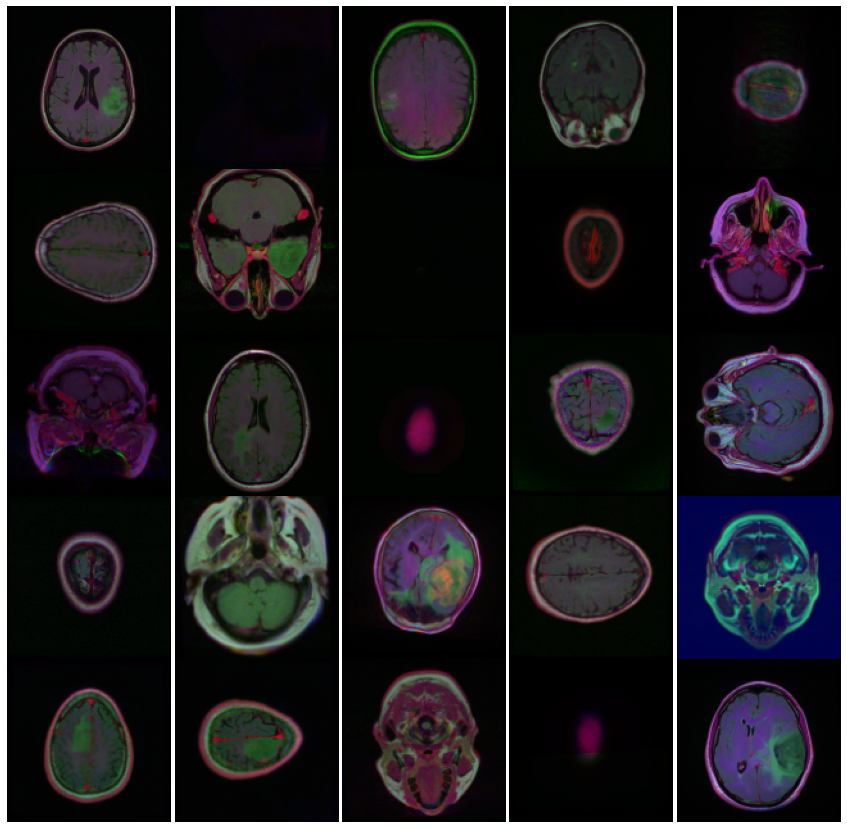

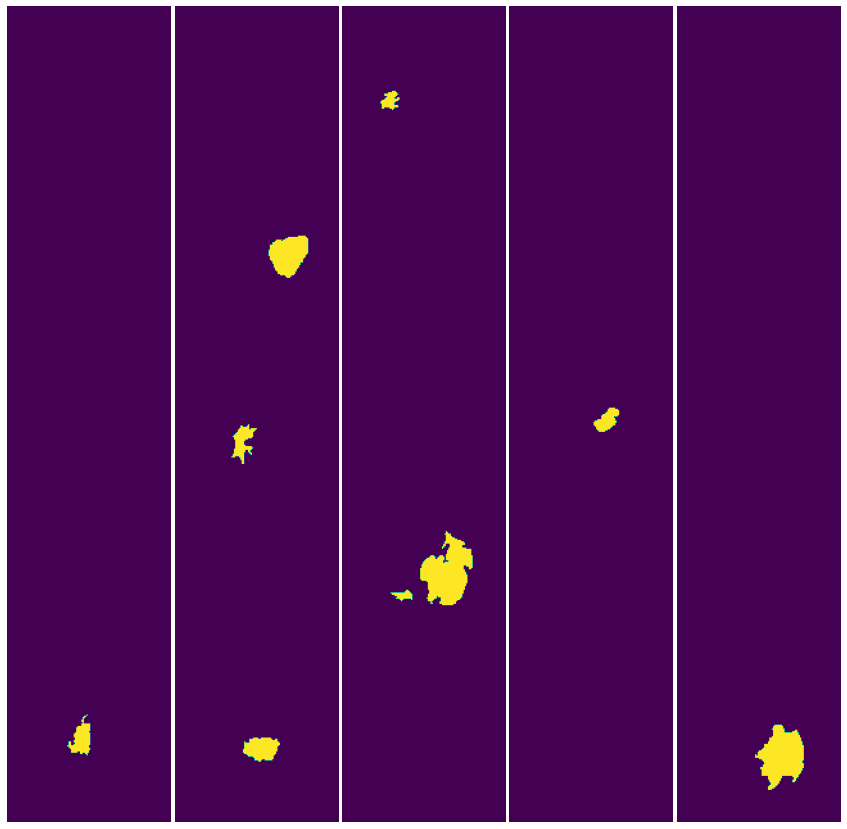

In [80]:
images, masks = next(iter(train_dataloader))
print(images.shape)
print(masks.shape)
show_aug(images)
show_aug(masks, image=False)

## 4. Create Model

In [41]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [42]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear)        
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [43]:
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 256, 256).to(device))
print(out.shape)

torch.Size([1, 1, 256, 256])


## 5. Metric and Loss Function

In [44]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

## 6. Train Model

In [45]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    with torch.no_grad():
        for step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += loss

    return valloss / step

In [49]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i, (image, mask) in enumerate(tqdm(train_loader)):
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
            
            train_dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            loss = loss_func(outputs, mask)
            losses.append(loss.item())
            train_iou.append(train_dice)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del image
            del mask
            gc.collect()
            torch.cuda.empty_cache()
                
        val_mean_iou = compute_iou(model, val_loader)
        scheduler.step(val_mean_iou)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print(f'Epoch : {epoch+1}/{num_epochs}')
        print(f'loss: {np.array(losses).mean():.3f} - dice_coef: {np.array(train_iou).mean():.3f} - val_dice_coef: {val_mean_iou:.3f}')


    return loss_history, train_history, val_history

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 10
loss_history, train_history, val_history = train_model(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)

100%|██████████| 116/116 [15:37<00:00,  8.08s/it]


Epoch : 1/10
loss: 0.424 - dice_coef: 0.630 - val_dice_coef: 0.659


100%|██████████| 116/116 [14:16<00:00,  7.39s/it]


Epoch : 2/10
loss: 0.381 - dice_coef: 0.664 - val_dice_coef: 0.772


100%|██████████| 116/116 [13:44<00:00,  7.11s/it]


Epoch : 3/10
loss: 0.351 - dice_coef: 0.689 - val_dice_coef: 0.770


100%|██████████| 116/116 [14:02<00:00,  7.26s/it]


Epoch : 4/10
loss: 0.342 - dice_coef: 0.699 - val_dice_coef: 0.712


100%|██████████| 116/116 [13:47<00:00,  7.14s/it]


Epoch : 5/10
loss: 0.333 - dice_coef: 0.706 - val_dice_coef: 0.743


100%|██████████| 116/116 [13:49<00:00,  7.15s/it]


Epoch : 6/10
loss: 0.329 - dice_coef: 0.709 - val_dice_coef: 0.726


100%|██████████| 116/116 [15:06<00:00,  7.81s/it]


Epoch : 7/10
loss: 0.294 - dice_coef: 0.740 - val_dice_coef: 0.805


100%|██████████| 116/116 [13:15<00:00,  6.85s/it]


Epoch : 8/10
loss: 0.278 - dice_coef: 0.754 - val_dice_coef: 0.759


100%|██████████| 116/116 [13:01<00:00,  6.73s/it]


Epoch : 9/10
loss: 0.269 - dice_coef: 0.762 - val_dice_coef: 0.779


100%|██████████| 116/116 [13:52<00:00,  7.18s/it]


Epoch : 10/10
loss: 0.271 - dice_coef: 0.760 - val_dice_coef: 0.768


## 7. Train History

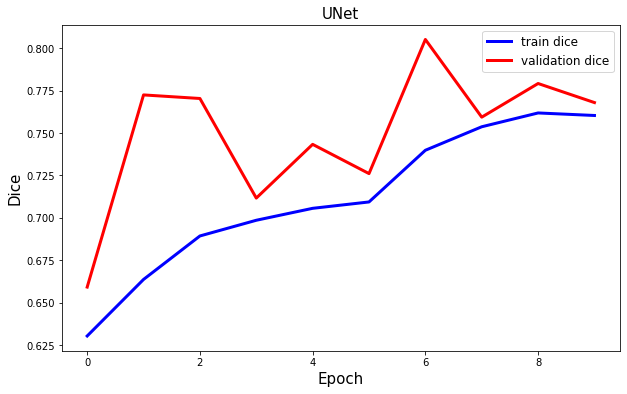

In [62]:
def plot_model_history(model_name, train_history, val_history, num_epochs):
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="b")
    plt.plot(x, val_history, label='validation dice', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Dice", fontsize=15)

    plt.show()
    
plot_model_history('UNet', train_history, val_history, num_epochs)

## 8. Prediction

In [63]:
test_iou = compute_iou(model, test_dataloader)
print(f"Mean IoU: {100*test_iou:.3f}%")

Mean IoU: 78.797%


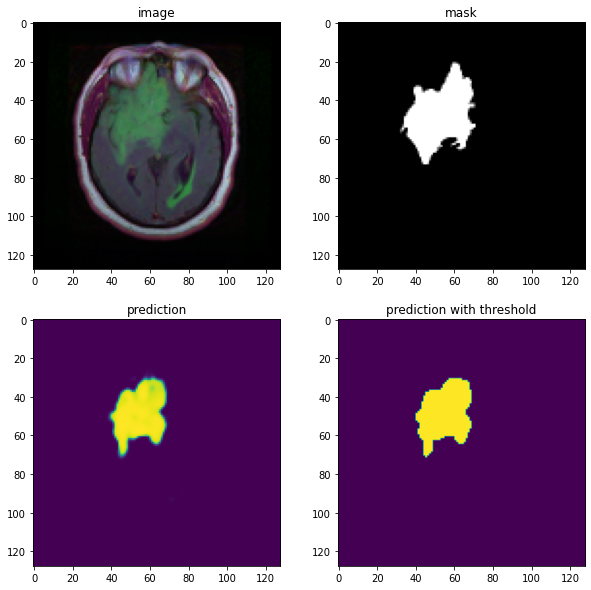

In [78]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()